In [1]:
import pandas as pd
import numpy as np
import torch

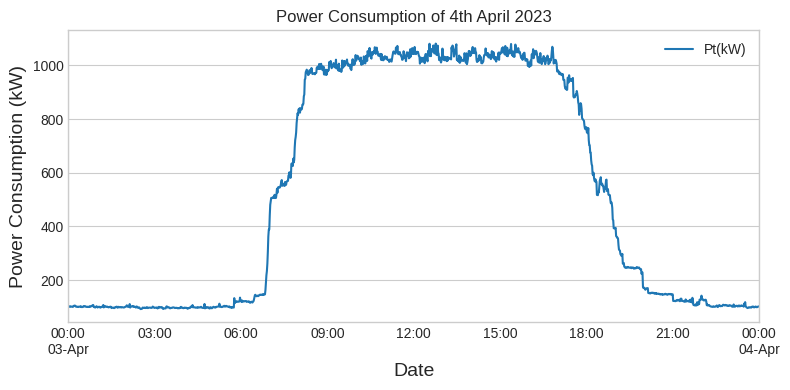

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('/content/combine_1.csv')

# Convert the 'Time' column to datetime objects
df['Time'] = pd.to_datetime(df['Time'])

# Filter the data for the specific date range
start_date = pd.to_datetime('2023-04-03')
end_date = pd.to_datetime('2023-04-04')
filtered_df = df[(df['Time'] >= start_date) & (df['Time'] <= end_date)]

# Plot the data with adjusted figure size and font sizes
plt.style.use('seaborn-v0_8-whitegrid')
filtered_df.plot(x='Time', y='Pt(kW)',
                 figsize=(8, 4),  # Smaller figure size
                 marker='o',
                 markersize=0,
                 linestyle='-',
                 title='Power Consumption of 4th April 2023')

# These lines increase the font size for the axis labels
plt.xlabel('Date', fontsize=14)
plt.ylabel('Power Consumption (kW)', fontsize=14)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('power_consumption_plot_modified.png')

------------------------------------------
# **1. Preparing the Dataset for Training** 😎😎

------------------------------------------------------------------
## **1.1 Ideal Threshold Calculation Function**

In [3]:
def calculate_effective_threshold(
    forecasted_load,
    initial_threshold,
    available_energy_kwh,
    max_power_kw = 100.0, # Added parameter for maximum discharge power
    interval_hours = 1 / 60): # Changed default interval to 5 minutes

  """
  Calculates the optimal peak shaving threshold by checking if the rationing logic is needed --> or rather if the battery capacity that handle the entire duration without adjustment

  Returns:
    The final, effective threshold (in kW) to be used for the day.
  """

  # Identify all the intervals where the load is more than the threshold set
  peak_intervals = forecasted_load[forecasted_load > initial_threshold]

  # If there is no peak to reduce, do nothing
  if peak_intervals.empty:
    return initial_threshold

  # Calculate the power needed in each peak interval, capped by max_power_kw
  power_needed_in_peaks = (peak_intervals - initial_threshold).clip(upper=max_power_kw)


  # Calculating the entire energy that is needed to reduce the demand based on the initial threshold
  # Use the capped power for energy calculation
  energy_needed_kwh = power_needed_in_peaks.sum() * interval_hours


  # Check if the battery has enough capacity for the energy that is needed
  if energy_needed_kwh <= available_energy_kwh:
    print(f"Initial threshold {initial_threshold:.2f} kW is feasible with available energy {available_energy_kwh:.2f} kWh.")
    return initial_threshold

  effective_threshold = initial_threshold

  # A while loop to raise the threshold by 1kW and see if the battery has enough energy to cover the energy that is needed
  while energy_needed_kwh > available_energy_kwh:
    effective_threshold += 1

    new_peak_intervals = forecasted_load[forecasted_load > effective_threshold]

    if new_peak_intervals.empty:
      effective_threshold = forecasted_load.max() # This is the absolute LIMIT, is just a failsafe
      break

    # Calculate the power needed for the new threshold, again capped by max_power_kw
    new_power_needed_in_peaks = (new_peak_intervals - effective_threshold).clip(upper=max_power_kw)

    # Recalculate energy needed with the new threshold and capped power
    energy_needed_kwh = new_power_needed_in_peaks.sum() * interval_hours


  # print(f"Effective threshold adjusted to {effective_threshold:.2f} kW (requires {energy_needed_kwh:.2f} kWh).")
  return effective_threshold

------------------------------------------------------------------
## **1.2 Preparing the Cyclical Time Data (Sin and Cos)**

In [4]:
# Reading the file
df = pd.read_csv('/content/combine_1.csv')

# Changing the Timestamp as datetime format and set it index
df.rename(columns = {'Time' : 'Timestamp'}, inplace = True)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.drop(columns = ['St(kVA)'], inplace = True)
df.set_index('Timestamp', inplace = True)

# Setting the intervals for the time
df['hour_of_day'] = df.index.hour
df['minute_of_day'] = df.index.minute

# Using the sin and cos for periodicity
intervals_per_day = 1440
df['TOD'] = (df['hour_of_day'] * 60 ) + (df['minute_of_day'])
df['TOD_sin'] = np.sin(2 * np.pi * df['TOD'] / intervals_per_day)
df['TOD_cos'] = np.cos(2 * np.pi * df['TOD'] / intervals_per_day)

# Removing the days that have a lower peak than 800kW --> these days are not in the interest of study
filtered_df = df

# Group by day and calculate the peak value for each day
daily_peak_load = df['Pt(kW)'].resample('D').max()

# Identify the rows where the peak values are lower than 800kW
days_to_remove = daily_peak_load[daily_peak_load < 800].index

# Remove these days from the original dataframe
df = df[~df.index.normalize().isin(days_to_remove)]

# Dropping the temporary columns --> hour and minute
df.drop(columns = ['hour_of_day', 'minute_of_day'], inplace = True)

df.head()

/tmp/ipython-input-3301285506.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns = ['hour_of_day', 'minute_of_day'], inplace = True)


,Pt(kW),TOD,TOD_sin,TOD_cos
Timestamp,,,,
2023-04-03 00:00:00,99.3316,0,0.000000,1.000000
2023-04-03 00:01:00,101.1692,1,0.004363,0.999990
2023-04-03 00:02:00,102.3316,2,0.008727,0.999962
2023-04-03 00:03:00,102.4148,3,0.013090,0.999914
2023-04-03 00:04:00,100.8152,4,0.017452,0.999848


------------------------------------------------------------------
## **1.3 Calculating the Ideal Threshold and Merge it with the Dataframe**

In [5]:
# Group the Dataframe by day
grouped_by_day = df.groupby(df.index.normalize())

# Initialize a list to store the daily ideal threshold
daily_ideal_thresholds = []

# Iterate through each day and calculate the ideal threshold
for day, daily_df in grouped_by_day:
  available_energy = 120.0
  initial_threshold = 600

  ideal_threshold = calculate_effective_threshold(
      daily_df['Pt(kW)'],
      initial_threshold,
      available_energy
  )
  daily_ideal_thresholds.append({'Day' : day, 'Ideal Threshold' : ideal_threshold})

# Converting the results into a Dataframe
daily_ideal_thresholds_df = pd.DataFrame(daily_ideal_thresholds)

display(daily_ideal_thresholds_df.head())

# Combining the ideal thresholds Dataframe to the original Dataframe
daily_ideal_thresholds_df['Day'] = pd.to_datetime(daily_ideal_thresholds_df['Day'])
df = df.merge(daily_ideal_thresholds_df, left_on = df.index.normalize(), right_on = 'Day', how = 'left')
display(df.head())


,Day,Ideal Threshold
0,2023-04-03,1020
1,2023-04-04,1011
2,2023-04-05,912
3,2023-04-06,980
4,2023-04-07,975


,Pt(kW),TOD,TOD_sin,TOD_cos,Day,Ideal Threshold
0,99.3316,0,0.000000,1.000000,2023-04-03,1020
1,101.1692,1,0.004363,0.999990,2023-04-03,1020
2,102.3316,2,0.008727,0.999962,2023-04-03,1020
3,102.4148,3,0.013090,0.999914,2023-04-03,1020
4,100.8152,4,0.017452,0.999848,2023-04-03,1020


In [6]:
df_final = df.copy()

# 1. Convert the 'Day' column to a proper timedate object
df_final['Day'] = pd.to_datetime(df_final['Day'])

# 2. Create a full timestamp by adding the 'TOD' in minutes to the date
df_final['Timestamp'] = df_final['Day'] + pd.to_timedelta(df_final['TOD'], unit = 'm')

# 3. Set this new 'Timestamp' column as the official index of the DataFrame
df_final = df_final.set_index('Timestamp')

# 4. Drop the redundant columns --> Already have extracted their information
df_final = df_final.drop(columns = ['Day', 'TOD'])

print(df_final.head())

                       Pt(kW)   TOD_sin   TOD_cos  Ideal Threshold
Timestamp                                                         
2023-04-03 00:00:00   99.3316  0.000000  1.000000             1020
2023-04-03 00:01:00  101.1692  0.004363  0.999990             1020
2023-04-03 00:02:00  102.3316  0.008727  0.999962             1020
2023-04-03 00:03:00  102.4148  0.013090  0.999914             1020
2023-04-03 00:04:00  100.8152  0.017452  0.999848             1020


In [7]:
ideal_results_list = []

# Group the entire DataFrame by day
grouped_by_day = df_final.groupby(df_final.index.normalize())

print("Calculating ideal reduction for all days in the dataset...")

# Loop through each day
for day, day_df in grouped_by_day:
    # --- Get the data for this specific day ---
    original_demand_profile = day_df['Pt(kW)'].values
    ideal_threshold_for_day = day_df['Ideal Threshold'].iloc[0]

    # --- Run the "Perfect Foresight" Simulation for this day ---
    ideal_reduced_profile = []
    remaining_capacity = 120.0
    for demand in original_demand_profile:
        reduced_demand = demand
        if demand > ideal_threshold_for_day:
            excess_power = demand - ideal_threshold_for_day
            discharge_power = min(excess_power, 100.0, remaining_capacity / (1/60))
            reduced_demand = demand - discharge_power
            remaining_capacity -= discharge_power * (1/60)
            if remaining_capacity < 0:
                remaining_capacity = 0
        ideal_reduced_profile.append(reduced_demand)

    # --- Calculate the 30-Minute Average Reduction for this day ---
    original_series = pd.Series(original_demand_profile)
    ideal_reduced_series = pd.Series(ideal_reduced_profile)

    original_30min_peak = original_series.rolling(window=30, min_periods=1).mean().max()
    ideal_reduced_30min_peak = ideal_reduced_series.rolling(window=30, min_periods=1).mean().max()

    ideal_reduction = original_30min_peak - ideal_reduced_30min_peak

    # --- Store the final result for this day ---
    ideal_results_list.append({
        'Date': day.date(),
        'Ideal_30Min_Reduction_kW': ideal_reduction,
        'Ideal_30Min_Peak_kW': ideal_reduced_30min_peak
    })

# --- Display the Final Results Table ---
ideal_results_df = pd.DataFrame(ideal_results_list)

print("\n✅ Calculation complete.")
display(ideal_results_df)

Calculating ideal reduction for all days in the dataset...

✅ Calculation complete.


,Date,Ideal_30Min_Reduction_kW,Ideal_30Min_Peak_kW
0,2023-04-03,31.891613,1020.000000
1,2023-04-04,36.534267,1011.000000
2,2023-04-05,40.905680,912.000000
3,2023-04-06,35.773281,979.925680
4,2023-04-07,40.406853,975.000000
...,...,...,...
459,2025-02-17,37.871667,1030.023333
460,2025-02-18,43.018333,997.935000
461,2025-02-19,37.973333,976.773333
462,2025-02-20,61.446667,987.180000


In [ ]:
ideal_results_df.to_csv('ideal_results.csv')

In [ ]:
daily_peaks = df_final['Pt(kW)'].groupby(df_final.index.normalize()).max()
historical_avg_peaks = daily_peaks.rolling(window=7, min_periods=1).mean().shift(1)

-----------------------------------------------------
## **1.4 Splitting the Dataset into Train Set and Test Set**

In [8]:
# Split the dataframe into train set and test set

# Define the date where to split the data
CUT_OFF_DATE = '2024-04-30'

# Create the training set with all the data BEFORE the cut-off date
train_df = df_final.loc[df_final.index < CUT_OFF_DATE]

# Create the testing set with all data ON or AFTER the cut-off date
test_df = df_final.loc[df_final.index >= CUT_OFF_DATE]

# Verify the shape of the train and test set
print(train_df.shape, test_df.shape)

(371520, 4) (296640, 4)


--------------------------------------------------------------------------
## **1.5 Preparing the Train and Test Set into Tensor Format for Training**

In [9]:
# 1. Defining the parameters
WINDOW_SIZE = 60
PEAK_START_TIME = pd.to_datetime('08:00').time()
PEAK_END_TIME = pd.to_datetime('16:00').time()
FEATURE_COLS = ['TOD_sin', 'TOD_cos', 'Pt(kW)']
TARGET_COL = 'Ideal Threshold'
MAXIMUM_POWER = 1246.4

# 2. Collect all Valid Windows from All Days
all_windows = []
all_labels = []

grouped_by_day = train_df.groupby(train_df.index.normalize())

for day, day_df in grouped_by_day:
  for i in range(WINDOW_SIZE, len(day_df)):
    target_timestamp = day_df.index[i]

    if PEAK_START_TIME <= target_timestamp.time() < PEAK_END_TIME:
      window = day_df[FEATURE_COLS].iloc[i - WINDOW_SIZE : i ].values
      label = day_df[TARGET_COL].iloc[i]
      all_windows.append(window)
      all_labels.append(label)

# Finalise the Tensors for the model
train_inputs = torch.tensor(np.array(all_windows), dtype = torch.float32)
train_targets = torch.tensor(np.array(all_labels), dtype = torch.float32)

# Normalize the tensors
train_inputs[:, :, 2] /= MAXIMUM_POWER
train_targets /= MAXIMUM_POWER

# Reshape for CNN
train_CNN = train_inputs.permute(0, 2, 1)

# Create the final list of (input, target) tuples
train_set = [(train_CNN[i], train_targets[i].unsqueeze(0)) for i in range(len(train_CNN))]

print("\n--- ✅ Workflow Complete ---")
print(f"Final train_set created with {len(train_set)} samples.")
print(f"Shape of one input sample: {train_set[0][0].shape}")


--- ✅ Workflow Complete ---
Final train_set created with 123840 samples.
Shape of one input sample: torch.Size([3, 60])


In [10]:
# --- Preparing the Test Set ---

# Collect all valid windows from all test days
all_test_windows = []
all_test_labels = []

grouped_by_day_test = test_df.groupby(test_df.index.normalize())

for day, day_df in grouped_by_day_test:
    for i in range(WINDOW_SIZE, len(day_df)):
        target_timestamp = day_df.index[i]

        if PEAK_START_TIME <= target_timestamp.time() < PEAK_END_TIME:
            window = day_df[FEATURE_COLS].iloc[i - WINDOW_SIZE : i].values
            label = day_df[TARGET_COL].iloc[i]
            all_test_windows.append(window)
            all_test_labels.append(label)

print(f"Found {len(all_test_windows)} total test samples.")

# Convert lists to tensors
test_inputs = torch.tensor(np.array(all_test_windows), dtype=torch.float32)
test_targets = torch.tensor(np.array(all_test_labels), dtype=torch.float32)

# Normalize using the MAXIMUM_POWER from the training set
test_inputs[:, :, 2] /= MAXIMUM_POWER
test_targets /= MAXIMUM_POWER

# Reshape for CNN
test_CNN = test_inputs.permute(0, 2, 1)

# Create the final list of (input, target) tuples
test_set = [(test_CNN[i], test_targets[i].unsqueeze(0)) for i in range(len(test_CNN))]

print("\n--- ✅ Test Set Ready ---")
print(f"Final test_set created with {len(test_set)} samples.")
print(f"Shape of one input sample: {test_set[0][0].shape}")

Found 98880 total test samples.

--- ✅ Test Set Ready ---
Final test_set created with 98880 samples.
Shape of one input sample: torch.Size([3, 60])


------------------------------------------------------------
# **2. Training the Model** 💪💪

In [ ]:
from torch import nn
from torch.utils.data import DataLoader
from google.colab import drive
import os

# Mounting Google Drive to save the model
drive.mount('/content/drive')

# --- 1. Define the Model Architecture ---
# Using CNN for time-series data
class CNN_Model(nn.Module):
  def __init__(self, num_features, window_size):
    super(CNN_Model, self).__init__()
    self.conv1 = nn.Conv1d(in_channels = num_features, out_channels = 16, kernel_size = 3, padding = 1)
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool1d(kernel_size = 2)
    self.flatten = nn.Flatten()
    # Calculate the flattened size after convolution and pooling
    flattened_size = 16 * (window_size // 2)
    self.fc1 = nn.Linear(flattened_size, 32)
    self.fc2 = nn.Linear(32, 1)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    return x

# --- 2. Setting the Hyperparameters ---
NUM_FEATURES =  train_set[0][0].shape[0] # Should have 3 --> sin, cos and power load
WINDOW_SIZE = train_set[0][0].shape[1] # Should be 60
LEARNING_RATE = 0.001
NUM_EPOCHS = 30
BATCH_SIZE = 64 # Batch size for the DataLoader

# --- 3. Prepare the DataLoader ---
train_loader = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_set, batch_size = BATCH_SIZE, shuffle = False)

# --- 4. Initializing the Model, Loss Function and the Optimizer ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_Model(num_features = NUM_FEATURES, window_size = WINDOW_SIZE).to(device)
criterion = nn.MSELoss() # Mean Squared Error is good for regression models
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)


# *** EXTRA:
best_validation_loss = float('inf')

# Define where to save the best model
SAVE_DIR = '/content/drive/MyDrive/FYP Project - Designing a controller to reduce peak demand/Specialist Model'
if not os.path.exists(SAVE_DIR):
  os.makedirs(SAVE_DIR)
BEST_MODEL_PATH = os.path.join(SAVE_DIR, 'best_specialist_model.pth')

# --- 5. The Training Loop / Process ---
for epoch in range(NUM_EPOCHS):
  # --- Training Phase ---
  model.train()
  total_train_loss = 0
  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    # Forward Pass
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    # Backward Pass and Optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_train_loss += loss.item()

  avg_train_loss = total_train_loss / len(train_loader)

  # --- Validation Phase --> Testing with the test data ---
  model.eval()
  total_test_loss = 0
  with torch.no_grad():
    for inputs, labels in test_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      total_test_loss += loss.item()

  avg_test_loss = total_test_loss / len(test_loader)

  print(f"Epoch [{epoch + 1} / {NUM_EPOCHS}], Training Loss: {avg_train_loss:.6f}, Validation Loss: {avg_test_loss:.6f}")

  # --- Check if this is the best model so far and save it ---
  if avg_test_loss < best_validation_loss:
    best_validation_loss = avg_test_loss
    torch.save(model.state_dict(), BEST_MODEL_PATH)
    print(f"New best model saved at Epoch {epoch + 1} with Validation Loss: {avg_test_loss:.6f}")

print("Congratulations, Training is COMPLETE!")
print(f"The BEST model is saved to {BEST_MODEL_PATH}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch [1 / 30], Training Loss: 0.002921, Validation Loss: 0.001089
New best model saved at Epoch 1 with Validation Loss: 0.001089
Epoch [2 / 30], Training Loss: 0.001657, Validation Loss: 0.001344
Epoch [3 / 30], Training Loss: 0.001597, Validation Loss: 0.001244
Epoch [4 / 30], Training Loss: 0.001560, Validation Loss: 0.001177
Epoch [5 / 30], Training Loss: 0.001511, Validation Loss: 0.001263
Epoch [6 / 30], Training Loss: 0.001473, Validation Loss: 0.001116
Epoch [7 / 30], Training Loss: 0.001424, Validation Loss: 0.001240
Epoch [8 / 30], Training Loss: 0.001399, Validation Loss: 0.001207
Epoch [9 / 30], Training Loss: 0.001384, Validation Loss: 0.001207
Epoch [10 / 30], Training Loss: 0.001380, Validation Loss: 0.001227
Epoch [11 / 30], Training Loss: 0.001360, Validation Loss: 0.001336
Epoch [12 / 30], Training Loss: 0.001362, Validation Loss: 0.001240
E

-----------------------------------------------------
# **3. Peak Reduction Simulation**

In [11]:
# Define the Model Class 'CNN_Model'
import torch.nn as nn

class CNN_Model(nn.Module):
  def __init__(self, num_features, window_size):
    super(CNN_Model, self).__init__()
    self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=16, kernel_size=3, padding=1)
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool1d(kernel_size=2)
    self.flatten = nn.Flatten()
    # Calculate the flattened size after convolution and pooling
    flattened_size = 16 * (window_size // 2)
    self.fc1 = nn.Linear(flattened_size, 32)
    self.fc2 = nn.Linear(32, 1)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    return x

In [ ]:
df_final['Ideal Threshold'].max()

1150

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Specialist Model is loaded successfully
Starting Simulation for 2024-10-15

 Instantaneous Peak:
  - Original Peak: 925.80 kW
  - Reduced Peak: 925.80 kW
  - Instantaneous Reduction: 0.00

30-Minute Average Peak:
  - Original 30-Minute Peak: 891.79 kW
  - Reduced 30-Minute Peak: 891.79 kW
  - Average Reduction: 0.00
Simulation is complete. Generating Plot ...


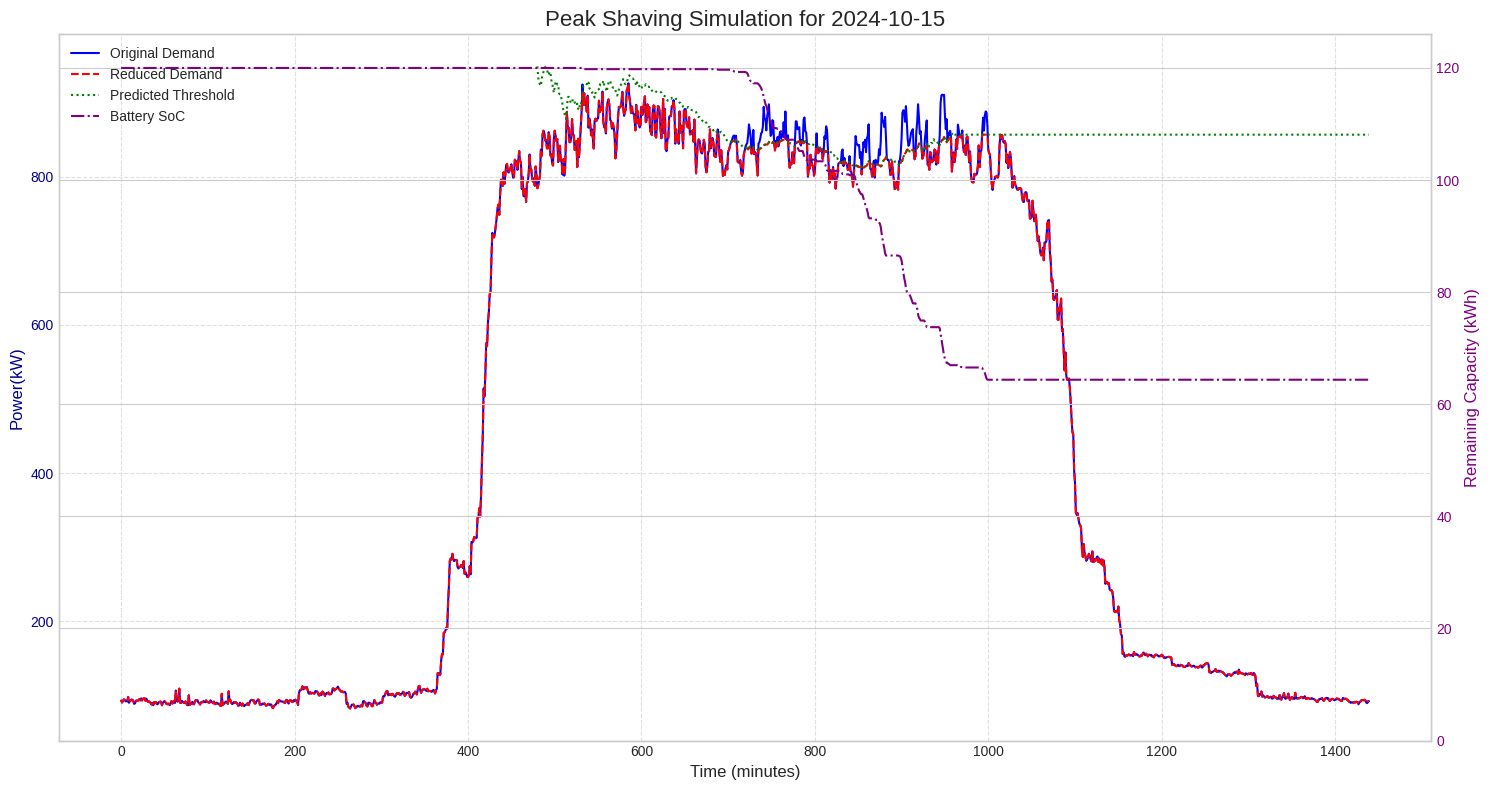

In [14]:
from google.colab import drive
import os
import matplotlib.pyplot as plt

# Mounting the Google Drive
drive.mount('/content/drive')

# Load the best model that is saved
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_Model(num_features = len(FEATURE_COLS), window_size = WINDOW_SIZE).to(device)

# Loading the model from the Google Drive
SAVE_DIR = '/content/drive/MyDrive/FYP Project - Designing a controller to reduce peak demand/Specialist Model'
BEST_MODEL_PATH = os.path.join(SAVE_DIR, 'best_specialist_model.pth')
model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location = device))

# Setting the model into evaluation mode
model.eval()
print("Specialist Model is loaded successfully")

# --- Selecting the day to simulate ---
DAY_TO_SIMULATE = 117
# Inside the loop for a given day...

all_test_days = list(test_df.groupby(test_df.index.normalize()))
day_timestamp, sim_day_df = all_test_days[DAY_TO_SIMULATE]

demand_profile = sim_day_df['Pt(kW)'].values
date_string = day_timestamp.strftime('%Y-%m-%d')

# current_date = day_timestamp.normalize()
# avg_historical_peak = historical_avg_peaks.get(current_date, default=900)
# DYNAMIC_MORNING_THRESHOLD = avg_historical_peak * 0.88

# --- 3. Initialize Simulation ---
print(f"Starting Simulation for {date_string}")

BATTERY_CAPACITY_KWH = 120.0
BATTERY_POWER_LIMIT_kW = 100.0
TIME_STEP_HOURS = 1 / 60
GRADIENT_WINDOW = 15
MORNING_WINDOW_END = 11 * 60
SMOOTHING_WINDOW = 15

adjust_factor = 0.0
remaining_capacity = BATTERY_CAPACITY_KWH
reduced_demand_profile = []
battery_soc_profile = []
threshold_profile = []


PEAK_START_MINUTE = PEAK_START_TIME.hour * 60
PEAK_END_MINUTE = PEAK_END_TIME.hour * 60

# --- 4. Simulation Loop ---

with torch.no_grad():
  for minute in range(len(sim_day_df)):
    current_demand = demand_profile[minute]
    reduced_demand_for_step = current_demand
    final_threshold = np.nan

    # Check if we are in the peak shaving window
    if PEAK_START_MINUTE <= minute < PEAK_END_MINUTE and minute >= WINDOW_SIZE:

      # --- Prepare the input window ---
      window_data = sim_day_df[FEATURE_COLS].iloc[minute - WINDOW_SIZE : minute].values
      window_tensor = torch.tensor(window_data, dtype = torch.float32).unsqueeze(0) # Adding the batch dimension

      # Normalize the power feature
      window_tensor[:, :, 2] /= MAXIMUM_POWER

      # Reshape for CNN and move to device
      cnn_input = window_tensor.permute(0, 2, 1).to(device)

      # --- Get the Model Prediction ---
      predicted_norm_threshold = model(cnn_input).item()

      # Denormalize the output to get the threshold values in kW
      predicted_threshold = predicted_norm_threshold * MAXIMUM_POWER
      final_threshold = predicted_threshold

      # past_15_load = demand_profile[minute-15 : minute]
      # if (past_15_load.mean() > 1100):
      #   final_threshold = min(final_threshold,1080)

      if remaining_capacity < (0.50 * BATTERY_CAPACITY_KWH) and minute == (13 * 60):
        adjust_factor = 30

      final_threshold += adjust_factor


      # if minute > 510 and minute < MORNING_WINDOW_END:
      #   energy_expected = (np.mean(demand_profile[minute - 5 : minute]) - final_threshold) * ((800 - minute) / 60)
      #   while(remaining_capacity > energy_expected):
      #     final_threshold -= 1
      #     energy_expected = (np.mean(demand_profile[minute - 5 : minute]) - final_threshold) * ((800 - minute) / 60)

      # if minute > MORNING_WINDOW_END and minute < (17 * 60):
      #   energy_expected = (np.mean(demand_profile[minute - 5 : minute]) - final_threshold) * ((1020 - minute) / 60)
      #   while(remaining_capacity < energy_expected):
      #     final_threshold += 1
      #     energy_expected = (np.mean(demand_profile[minute - 5 : minute]) - final_threshold) * ((1020 - minute) / 60)

      # if remaining_capacity < (0.5 * BATTERY_CAPACITY_KWH) and minute > (13 * 60):
      #  final_threshold += 10

    # if remaining_capacity < (0.30 * BATTERY_CAPACITY_KWH) and (minute > (13 * 60) and minute < (17 * 60)):
    #     energy_expected = (np.mean(demand_profile[minute - 5 : minute]) - final_threshold) * ((1020 - minute) / 60)
    #     while(remaining_capacity < energy_expected):
    #       final_threshold += 1
    #       energy_expected = (np.mean(demand_profile[minute - 5 : minute]) - final_threshold) * ((1020 - minute) / 60)

    if minute > PEAK_END_MINUTE:
      final_threshold = predicted_threshold

    # Apply the Peak Shaving Logic
    if current_demand > final_threshold:
      excess_power = current_demand - final_threshold
      discharge_power = min(excess_power, BATTERY_POWER_LIMIT_kW, remaining_capacity  / TIME_STEP_HOURS)
      if (minute < MORNING_WINDOW_END):
        discharge_power = min(excess_power, 30)
      reduced_demand_for_step = current_demand - discharge_power
      remaining_capacity -= discharge_power * TIME_STEP_HOURS

    # Record the results for this minute
    reduced_demand_profile.append(reduced_demand_for_step)
    battery_soc_profile.append(remaining_capacity)
    threshold_profile.append(final_threshold)

# Calculating the performance metrics

# --- 1. Instantaneous Peak Reduction ---
original_peak = max(demand_profile)
reduced_peak = max(reduced_demand_profile)
instanteous_reduction = original_peak - reduced_peak

print(f"\n Instantaneous Peak:")
print(f"  - Original Peak: {original_peak:.2f} kW")
print(f"  - Reduced Peak: {reduced_peak:.2f} kW")
print(f"  - Instantaneous Reduction: {instanteous_reduction:.2f}")

# --- 2. 30-Minute Average Peak Reduction (Utility Observation) ---

# Converting the lists to Pandas Series to calculate the rolling average
original_series = pd.Series(demand_profile)
reduced_series = pd.Series(reduced_demand_profile)

# Calculating the 30-minute rolling average for both profiles
rolling_avg_original = original_series.rolling(window = 30).mean()
rolling_avg_reduced = reduced_series.rolling(window = 30).mean()

# Find the peak of the rolling average profiles
original_30min_peak = rolling_avg_original.max()
reduced_30min_peak = rolling_avg_reduced.max()
avg_reduction = original_30min_peak - reduced_30min_peak

print(f"\n30-Minute Average Peak:")
print(f"  - Original 30-Minute Peak: {original_30min_peak:.2f} kW")
print(f"  - Reduced 30-Minute Peak: {reduced_30min_peak:.2f} kW")
print(f"  - Average Reduction: {avg_reduction:.2f}")

# --- 5. Visualizing the results ---
print("Simulation is complete. Generating Plot ...")

fig, ax1 = plt.subplots(figsize = (15,8))
x_axis = np.arange(len(demand_profile))

# Plot the power data on the primary y-axis
ax1.set_xlabel('Time (minutes)', fontsize = 12)
ax1.set_ylabel('Power(kW)', color = 'darkblue', fontsize =12)
ax1.plot(x_axis, demand_profile, color = 'blue', label = 'Original Demand')
ax1.plot(x_axis, reduced_demand_profile, color = 'red', linestyle = '--', label = 'Reduced Demand')
ax1.plot(x_axis, threshold_profile, color = 'green', linestyle = ':', label = 'Predicted Threshold')
ax1.tick_params(axis = 'y', labelcolor = 'darkblue')
ax1.grid(True, linestyle = '--', alpha = 0.6)

# Plot the Battery Data on the secondary axis
ax2 = ax1.twinx()
ax2.set_ylabel('Remaining Capacity (kWh)', color = 'purple', fontsize = 12)
ax2.plot(x_axis, battery_soc_profile, color = 'purple', linestyle = '-.', label = 'Battery SoC')
ax2.tick_params(axis = 'y', labelcolor = 'purple')
ax2.set_ylim(0, BATTERY_CAPACITY_KWH * 1.05)

# Create a single legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc = 'upper left')

plt.title(f'Peak Shaving Simulation for {date_string}', fontsize = 16)
plt.tight_layout()
plt.show()

In [ ]:
import torch
import numpy as np
import pandas as pd

# --- 1. SETUP: Load Model and Define Parameters ---

# Assume CNN_Model class, test_df, and all parameters are defined
# Make sure to load your BEST 3-FEATURE model (e.g., from Epoch 10)
NUM_FEATURES = 3 # Using the 3-feature model
model = CNN_Model(num_features=NUM_FEATURES, window_size=WINDOW_SIZE).to(device)
# BEST_MODEL_PATH = 'path/to/your/best_3_feature_model.pth' # IMPORTANT: Use the correct path
model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
model.eval()
print("Model loaded. Starting batch simulation...")

# This list will store the results from every day
results_list = []
all_test_days = list(test_df.groupby(test_df.index.normalize()))

# --- 2. MAIN LOOP: Iterate Through Each Day in the Test Set ---

for day_timestamp, sim_day_df in all_test_days:
    date_string = day_timestamp.strftime('%Y-%m-%d')
    adjust_factor = 0.0
    print(f"  -> Simulating day: {date_string}")

    # --- 3. SIMULATION LOGIC (for one day) ---
    remaining_capacity = BATTERY_CAPACITY_KWH
    demand_profile = sim_day_df['Pt(kW)'].values
    reduced_demand_profile = []

    for minute in range(len(sim_day_df)):
        current_demand = sim_day_df['Pt(kW)'].iloc[minute]
        reduced_demand_for_step = current_demand

        if PEAK_START_MINUTE <= minute < PEAK_END_MINUTE and minute >= WINDOW_SIZE:
            window_data = sim_day_df[FEATURE_COLS].iloc[minute - WINDOW_SIZE : minute].values
            window_tensor = torch.tensor(window_data, dtype=torch.float32).unsqueeze(0)
            window_tensor[:, :, 2] /= MAXIMUM_POWER
            cnn_input = window_tensor.permute(0, 2, 1).to(device)

            with torch.no_grad():
                predicted_threshold = model(cnn_input).item() * MAXIMUM_POWER

            # --- Dynamic Safety Buffer Logic ---
            final_threshold = predicted_threshold

            past_15_load = demand_profile[minute-15 : minute]
            if (past_15_load.mean() > 1100):
              final_threshold = min(final_threshold, 1070)


        if remaining_capacity < (0.50 * BATTERY_CAPACITY_KWH) and minute == (13 * 60):
            adjust_factor = 30

        final_threshold += adjust_factor

        # if remaining_capacity < (0.30 * BATTERY_CAPACITY_KWH) and (minute > (13 * 60) and minute < (17 * 60)):
        #   energy_expected = (np.mean(demand_profile[minute - 5 : minute]) - final_threshold) * ((1020 - minute) / 60)
        #   while(remaining_capacity < energy_expected):
        #     final_threshold += 1
        #     energy_expected = (np.mean(demand_profile[minute - 5 : minute]) - final_threshold) * ((1020 - minute) / 60)

        if minute > PEAK_END_MINUTE:
            final_threshold = predicted_threshold

        if current_demand > final_threshold:
            excess_power = current_demand - final_threshold
            discharge_power = min(excess_power, BATTERY_POWER_LIMIT_kW, remaining_capacity / TIME_STEP_HOURS)
            if (minute < MORNING_WINDOW_END):
              discharge_power = min(excess_power, 30)
            reduced_demand_for_step = current_demand - discharge_power
            remaining_capacity -= discharge_power * TIME_STEP_HOURS

        reduced_demand_profile.append(reduced_demand_for_step)

    # --- 4. CALCULATE METRICS (for that one day) ---
    original_demand_profile = sim_day_df['Pt(kW)'].values

    # Instantaneous
    original_peak = np.max(original_demand_profile)
    reduced_peak = np.max(reduced_demand_profile)

    # 30-Min Average
    rolling_avg_original = pd.Series(original_demand_profile).rolling(window=30).mean().max()
    rolling_avg_reduced = pd.Series(reduced_demand_profile).rolling(window=30).mean().max()

    # Store results
    results_list.append({
        'Date': date_string,
        'Original_Peak_kW': original_peak,
        'Reduced_Peak_kW': reduced_peak,
        'Original_30Min_Peak_kW': rolling_avg_original,
        'Reduced_30Min_Peak_kW': rolling_avg_reduced
    })

# --- 5. FINAL RESULTS ---
print("\n--- ✅ Batch Simulation Complete ---")
results_df = pd.DataFrame(results_list)

# Calculate the reduction columns
results_df['Instant_Reduction_kW'] = results_df['Original_Peak_kW'] - results_df['Reduced_Peak_kW']
results_df['30Min_Avg_Reduction_kW'] = results_df['Original_30Min_Peak_kW'] - results_df['Reduced_30Min_Peak_kW']

# Display the final results table
display(results_df)

# Display the average performance across all test days
print("\n--- Average Performance Across All Test Days ---")
print(results_df[['Instant_Reduction_kW', '30Min_Avg_Reduction_kW']].mean())

Model loaded. Starting batch simulation...
  -> Simulating day: 2024-04-30
  -> Simulating day: 2024-05-01
  -> Simulating day: 2024-05-02
  -> Simulating day: 2024-05-03
  -> Simulating day: 2024-05-06
  -> Simulating day: 2024-05-07
  -> Simulating day: 2024-05-08
  -> Simulating day: 2024-05-09
  -> Simulating day: 2024-05-10
  -> Simulating day: 2024-05-13
  -> Simulating day: 2024-05-14
  -> Simulating day: 2024-05-15
  -> Simulating day: 2024-05-16
  -> Simulating day: 2024-05-17
  -> Simulating day: 2024-05-20
  -> Simulating day: 2024-05-21
  -> Simulating day: 2024-05-23
  -> Simulating day: 2024-05-24
  -> Simulating day: 2024-05-27
  -> Simulating day: 2024-05-28
  -> Simulating day: 2024-05-29
  -> Simulating day: 2024-05-30
  -> Simulating day: 2024-05-31
  -> Simulating day: 2024-06-03
  -> Simulating day: 2024-06-04
  -> Simulating day: 2024-06-05
  -> Simulating day: 2024-06-06
  -> Simulating day: 2024-06-07
  -> Simulating day: 2024-06-10
  -> Simulating day: 2024-06-

,Date,Original_Peak_kW,Reduced_Peak_kW,Original_30Min_Peak_kW,Reduced_30Min_Peak_kW,Instant_Reduction_kW,30Min_Avg_Reduction_kW
0,2024-04-30,1122.40,1071.250000,1087.488333,1066.854089,51.150000,20.634245
1,2024-05-01,1043.95,986.328397,1014.698333,982.177062,57.621603,32.521271
2,2024-05-02,1112.55,1045.173514,1077.131667,1041.397721,67.376486,35.733946
3,2024-05-03,1046.70,992.060931,1012.855000,984.639340,54.639069,28.215660
4,2024-05-06,1136.00,1070.090495,1094.605000,1064.339400,65.909505,30.265600
...,...,...,...,...,...,...,...
201,2025-02-17,1107.60,1044.839277,1067.895000,1033.539822,62.760723,34.355178
202,2025-02-18,1086.55,1056.600000,1040.953333,1010.435669,29.950000,30.517664
203,2025-02-19,1094.60,1002.950000,1014.746667,985.247023,91.650000,29.499644
204,2025-02-20,1100.10,1100.100000,1048.626667,1001.739239,0.000000,46.887428



--- Average Performance Across All Test Days ---
Instant_Reduction_kW      48.397342
30Min_Avg_Reduction_kW    22.986512
dtype: float64


In [ ]:
results_df.iloc[190]

,190
Date,2025-01-31
Original_Peak_kW,896.25
Reduced_Peak_kW,874.3
Original_30Min_Peak_kW,855.548333
Reduced_30Min_Peak_kW,843.952195
Instant_Reduction_kW,21.95
30Min_Avg_Reduction_kW,11.596138


In [ ]:
results_df.to_csv('17-08-2025 1628.csv')

In [ ]:
sliced_ideal_results = ideal_results_df.iloc[258:]

In [ ]:
sliced_ideal_results

,Date,Ideal_30Min_Reduction_kW,Ideal_30Min_Peak_kW
258,2024-04-30,32.488333,1055.000000
259,2024-05-01,46.698333,968.000000
260,2024-05-02,56.131667,1021.000000
261,2024-05-03,44.855000,968.000000
262,2024-05-06,41.605000,1053.000000
...,...,...,...
459,2025-02-17,37.871667,1030.023333
460,2025-02-18,43.018333,997.935000
461,2025-02-19,37.973333,976.773333
462,2025-02-20,61.446667,987.180000


In [ ]:
import pandas as pd

# --- 1. Define your file path and column names ---
CSV_FILE_PATH = '/content/17-08-2025 1616.csv'

# --- PLEASE REPLACE THESE WITH YOUR ACTUAL COLUMN NAMES ---
DATE_COLUMN = 'Date'
ORIGINAL_PEAK_COLUMN = 'Original_30Min_Peak_kW'
REDUCED_PEAK_COLUMN = 'Reduced_30Min_Peak_kW'
IDEAL_PEAK_COLUMN = 'Ideal_30Min_Peak_kW'

# --- 2. Load the CSV and prepare the DataFrame ---
# Load the data
daily_peaks_df = pd.read_csv(CSV_FILE_PATH)
# Convert the date column to a proper datetime format
daily_peaks_df[DATE_COLUMN] = pd.to_datetime(daily_peaks_df[DATE_COLUMN])
sliced_ideal_results[DATE_COLUMN] = pd.to_datetime(sliced_ideal_results[DATE_COLUMN])

# Merge the two dataframes
merged_df = pd.merge(daily_peaks_df, sliced_ideal_results[[DATE_COLUMN, IDEAL_PEAK_COLUMN]], on=DATE_COLUMN, how='left')

# --- 3. Group by Month and Find the Maximum Peak in Each Group ---
# We group by the month of each date and apply the .max() function to find the highest peak in each group.
monthly_peaks = merged_df.groupby(merged_df[DATE_COLUMN].dt.to_period('M')).max()

# --- 4. Display the Final Table ---
# Rename the columns for clarity
monthly_peaks = monthly_peaks.rename(columns={
    ORIGINAL_PEAK_COLUMN: 'Original_Monthly_Peak_kW',
    REDUCED_PEAK_COLUMN: 'Reduced_Monthly_Peak_kW',
    IDEAL_PEAK_COLUMN: 'Ideal_Monthly_Peak_kW'
})


# Calculate the reduction
monthly_peaks['Monthly_Reduction_kW'] = monthly_peaks['Original_Monthly_Peak_kW'] - monthly_peaks['Reduced_Monthly_Peak_kW']
monthly_peaks['Ideal_Monthly_Reduction_kW'] = monthly_peaks['Original_Monthly_Peak_kW'] - monthly_peaks['Ideal_Monthly_Peak_kW']
monthly_peaks['Reduction Factor'] = monthly_peaks['Monthly_Reduction_kW'] / monthly_peaks['Ideal_Monthly_Reduction_kW']

print("\n--- ✅ Monthly Peak Demand Reduction ---")
# We only need to display the relevant columns
display(monthly_peaks[['Original_Monthly_Peak_kW', 'Reduced_Monthly_Peak_kW', 'Monthly_Reduction_kW', 'Ideal_Monthly_Reduction_kW', 'Reduction Factor']])


--- ✅ Monthly Peak Demand Reduction ---


/tmp/ipython-input-4200088354.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sliced_ideal_results[DATE_COLUMN] = pd.to_datetime(sliced_ideal_results[DATE_COLUMN])


,Original_Monthly_Peak_kW,Reduced_Monthly_Peak_kW,Monthly_Reduction_kW,Ideal_Monthly_Reduction_kW,Reduction Factor
Date,,,,,
2024-04,1087.488333,1066.854089,20.634244,32.488333,0.635128
2024-05,1094.605000,1066.726444,27.878556,41.605000,0.670077
2024-06,1126.295000,1108.299644,17.995356,42.295000,0.425472
2024-07,1119.615000,1104.304088,15.310912,40.685000,0.376328
2024-08,1116.590000,1088.289965,28.300035,38.590000,0.733352
2024-09,1082.998333,1069.508198,13.490135,52.998333,0.254539
2024-10,1046.288333,1015.573297,30.715036,57.288333,0.536148
2024-11,1077.725000,1034.969978,42.755022,71.725000,0.596097
2024-12,1010.120000,985.651444,24.468556,38.120000,0.641882


In [ ]:
monthly_peaks.to_csv('17-08-2025 1628_MDRF.csv')

In [ ]:
display(monthly_peaks)

,Unnamed: 0,Date,Original_Peak_kW,Reduced_Peak_kW,Original_Monthly_Peak_kW,Reduced_Monthly_Peak_kW,Instant_Reduction_kW,30Min_Avg_Reduction_kW,Ideal Reduction,Reduction Factor,Ideal_Monthly_Peak_kW,Monthly_Reduction_kW,Ideal_Monthly_Reduction_kW
Date,,,,,,,,,,,,,
2024-04,0.0,2024-04-30,1122.400,1071.250000,1087.488333,1066.854089,51.150000,20.634245,32.488333,0.635128,1055.000000,20.634244,32.488333
2024-05,22.0,2024-05-31,1160.700,1076.382962,1094.605000,1066.726444,100.000000,41.952343,64.343333,0.670077,1053.000000,27.878556,41.605000
2024-06,42.0,2024-06-28,1163.450,1123.500000,1126.295000,1103.054696,81.403946,38.426809,78.406667,0.549481,1084.000000,23.240304,42.295000
2024-07,65.0,2024-07-31,1166.250,1157.600000,1119.615000,1107.691667,94.161099,39.109473,60.380000,0.293065,1078.930000,11.923333,40.685000
2024-08,87.0,2024-08-30,1148.650,1121.700000,1116.590000,1087.956632,75.823846,34.469939,65.838333,0.741989,1078.000000,28.633368,38.590000
2024-09,106.0,2024-09-30,1117.400,1100.750000,1082.998333,1069.508198,88.685703,38.269850,79.266667,0.254539,1030.000000,13.490135,52.998333
2024-10,129.0,2024-10-31,1078.750,1020.101264,1046.288333,1015.573297,81.469978,31.669151,71.163333,0.536148,989.000000,30.715036,57.288333
2024-11,150.0,2024-11-29,1108.300,1038.310638,1077.725000,1034.969978,81.850166,42.755022,73.475000,0.596097,1006.000000,42.755022,71.725000
2024-12,170.0,2024-12-31,1067.375,1008.400000,1010.120000,985.651444,88.975000,73.349079,95.988333,0.641882,972.000000,24.468556,38.120000
